In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt

In [2]:
data = pd.read_csv("./Champagne_Monthly_Sales.csv", index_col='Month', parse_dates=True)
data.index.freq='MS'
data.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


<AxesSubplot:xlabel='Month'>

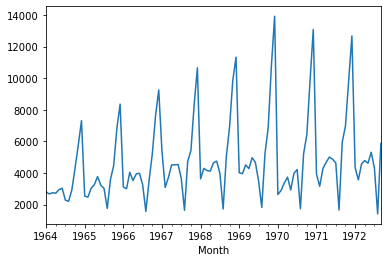

In [3]:
data['Sales'].plot()

In [4]:
train_size = int(data.shape[0]*0.8)
X_train = data.iloc[:train_size]
X_test = data.iloc[train_size:]

In [5]:
def plot_graph(train, test, test_col1, test_col2, col2_label):
    plt.figure(figsize = (12,8))
    plt.plot(train, label='Train')
    plt.plot(test[test_col1], label='test')
    plt.plot(test[test_col2], label=col2_label)
    plt.legend(loc='best')
    plt.show()

In [6]:
from sklearn.metrics import mean_squared_error
def calc_residual(y_test, actual_col, pred_col):
    rmse = np.sqrt(mean_squared_error(y_test[actual_col], y_test[pred_col]))
    abs_error = np.abs(y_test[actual_col] - y_test[pred_col])
    mape = np.round(np.mean(abs_error/y_test[actual_col]), 3)
    return rmse, mape

### Method 1. Simple Average

In Simple Average method, the prediction part is equal to the average of the training data.

In [7]:
X_test['simple_avg'] = X_train['Sales'].mean()

K:\MachineLearning\logistic_regression\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


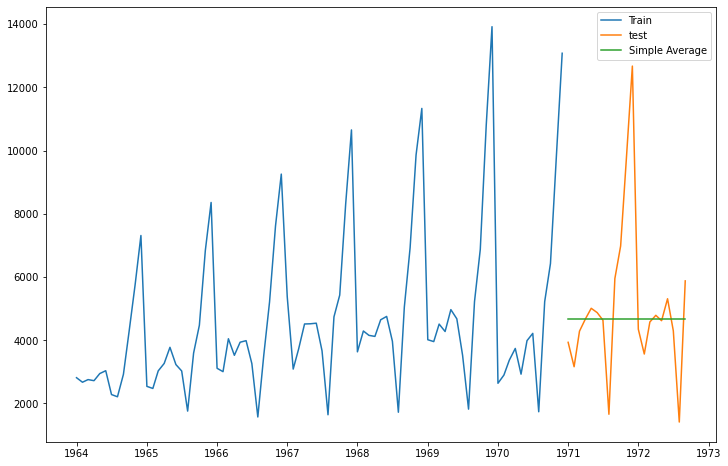

In [8]:
plot_graph(X_train['Sales'], X_test, 'Sales', 'simple_avg', 'Simple Average')

In [10]:
sa_rmse, sa_mape = calc_residual(X_test, 'Sales', 'simple_avg')

comparing_list = [['Simple Average', sa_rmse, sa_mape]]
comparing_list

[['Simple Average', 2427.5395216954603, 0.361]]

### Moving Average

Here we create a sliding window and calculate the average of data within that window.
The sliding window will move as the forecasting step moves ahead.

In [11]:
def calc_moving_average(df, iterations=10):
    
    for i in range(1, iterations):
        df['moving_average'] = df['Sales'].rolling(i).mean()
        
        X_test = df.iloc[84:]
        X_train = df.iloc[:84]
        ma_rmse, ma_mape = calc_residual(X_test, 'Sales', 'moving_average')
        print("iteration {}, rmse {}, mape {}".format(i, ma_rmse, ma_mape))
        
calc_moving_average(data, 12)

iteration 1, rmse 0.0, mape 0.0
iteration 2, rmse 1658.3717667238147, mape 0.282
iteration 3, rmse 2247.5259166540764, mape 0.447
iteration 4, rmse 2488.4410047112974, mape 0.516
iteration 5, rmse 2611.997619046534, mape 0.545
iteration 6, rmse 2551.734902874957, mape 0.538
iteration 7, rmse 2461.326695709579, mape 0.51
iteration 8, rmse 2442.749036872772, mape 0.513
iteration 9, rmse 2543.0166368941204, mape 0.561
iteration 10, rmse 2554.7161107776083, mape 0.555
iteration 11, rmse 2521.2763652633203, mape 0.526


<AxesSubplot:xlabel='Month'>

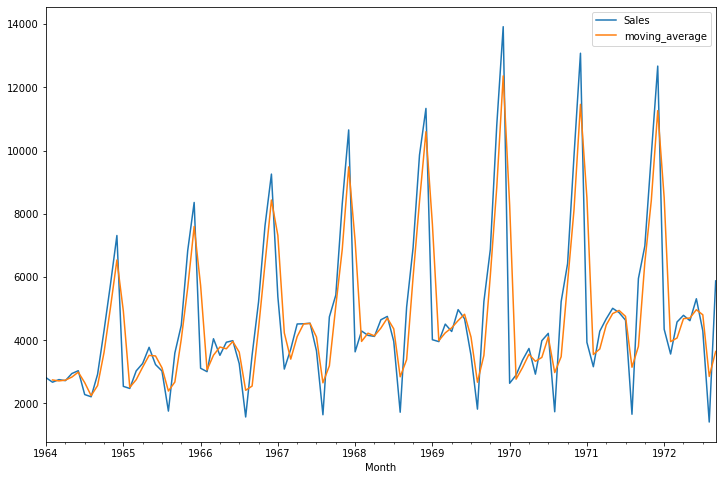

In [12]:
#Here I can see iteration has lower residuals
data1 = data.copy()
data1['moving_average'] = data1['Sales'].rolling(2).mean()
data1.plot(figsize = (12, 8))

In [13]:
X_test_ma = data1.iloc[84:]
X_train_ma = data1.iloc[:84]
ma_rmse, ma_mape = calc_residual(X_test_ma, 'Sales', 'moving_average')

In [16]:
comparing_list.append(['moving average', ma_rmse, ma_mape])
comparing_list

[['Simple Average', 2427.5395216954603, 0.361],
 ['moving average', 1658.3717667238147, 0.282]]

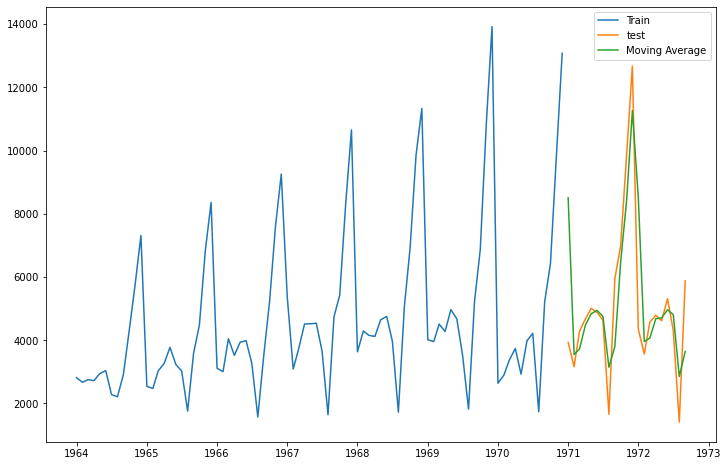

In [17]:
plot_graph(X_train_ma['Sales'], X_test_ma, 'Sales', 'moving_average', 'Moving Average')

### Method 3. Simple Exponential Smoothing

K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
K:\MachineLearning\logistic_regression\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


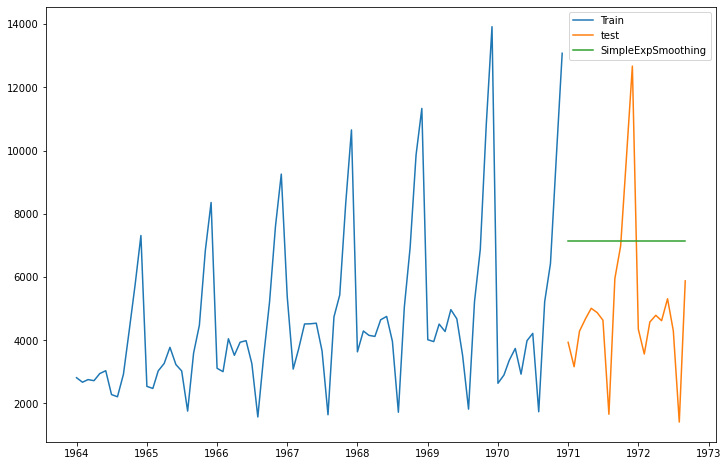

In [18]:
model_ses = SimpleExpSmoothing(X_train)
model_ses_fit = model_ses.fit(smoothing_level = 0.2, optimized = False)
X_test['SES'] = model_ses_fit.forecast(X_test.shape[0])
ses_rmse, ses_mape = calc_residual(X_test, 'Sales', 'SES')
plot_graph(X_train['Sales'], X_test, 'Sales', 'SES', 'SimpleExpSmoothing')

In [19]:
comparing_list.append(['SimpleExpSm0othing', ses_rmse, ses_mape])
comparing_list

[['Simple Average', 2427.5395216954603, 0.361],
 ['moving average', 1658.3717667238147, 0.282],
 ['SimpleExpSm0othing', 3170.8440801349334, 0.833]]

### Holt linear Trend Method OR Double Exponential Smoothing

K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
K:\MachineLearning\logistic_regression\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


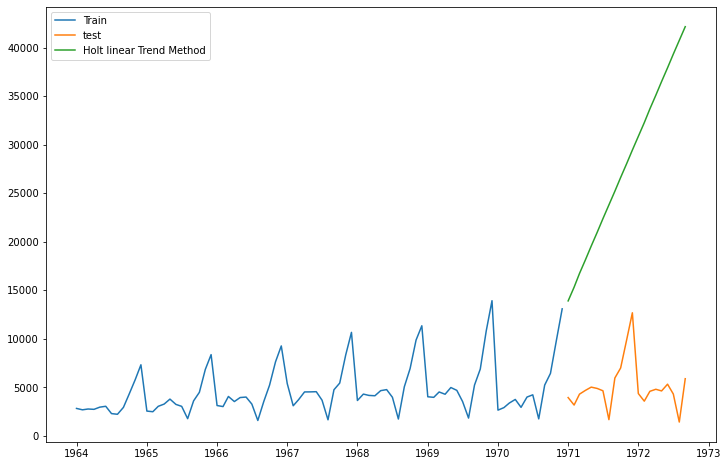

In [21]:
model_DES = Holt(X_train)
model_DES_fit = model_DES.fit(smoothing_level=0.8, smoothing_trend=0.2,  optimized = False)
X_test['DES'] = model_DES_fit.forecast(X_test.shape[0])
plot_graph(X_train['Sales'], X_test, 'Sales', 'DES', 'Holt linear Trend Method')

In [22]:
rmse_lt, mape_lt = calc_residual(X_test, 'Sales', 'DES')
comparing_list.append(['Holt linear Trend Method', rmse_lt, mape_lt])

K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
K:\MachineLearning\logistic_regression\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


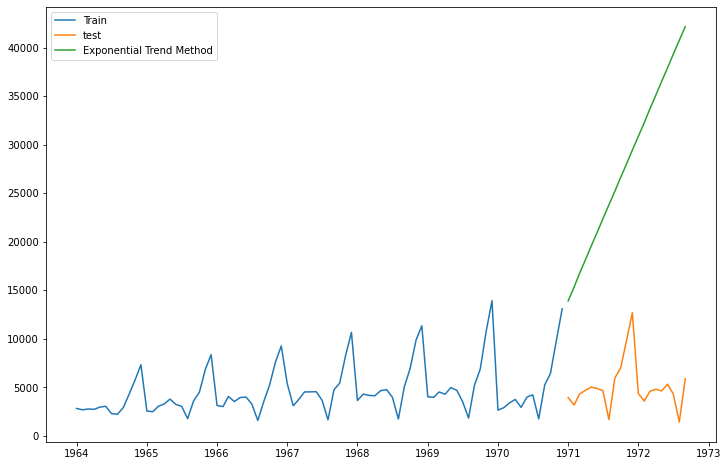

In [23]:
model_DES_exp = Holt(X_train, exponential=True)
model_DES_exp_fit = model_DES_exp.fit(smoothing_level=0.8, smoothing_trend=0.2,  optimized = False)
X_test['DES_exp'] = model_DES_exp_fit.forecast(X_test.shape[0])
plot_graph(X_train['Sales'], X_test, 'Sales', 'DES', 'Exponential Trend Method')

In [24]:
rmse_exp, mape_exp = calc_residual(X_test, 'Sales', 'DES_exp')
comparing_list.append(['Exponential Trend Method', rmse_exp, mape_exp])

K:\MachineLearning\logistic_regression\venv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  """Entry point for launching an IPython kernel.
K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
K:\MachineLearning\logistic_regression\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separ

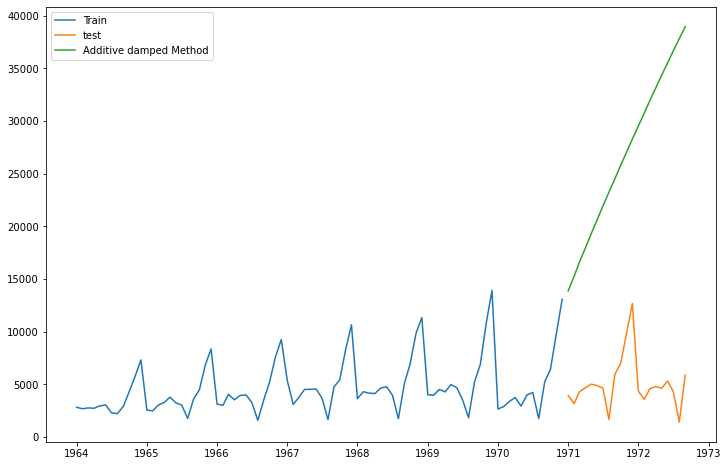

In [25]:
model_DES_ad_exp = Holt(X_train, damped=True)
model_DES_ad_fit = model_DES_ad_exp.fit(smoothing_level=0.8, smoothing_trend=0.2)
X_test['DES_damped'] = model_DES_ad_fit.forecast(X_test.shape[0])
plot_graph(X_train['Sales'], X_test, 'Sales', 'DES_damped', 'Additive damped Method')

In [26]:
rmse_damped, mape_damped = calc_residual(X_test, 'Sales', 'DES_damped')
comparing_list.append(['Additive damped Method', rmse_exp, mape_exp])

### Holt Winter Method

In [28]:
temp_test =pd.DataFrame(X_test['Sales'])

K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning


fit1: rmse 421.40387504737186 and mape 0.094


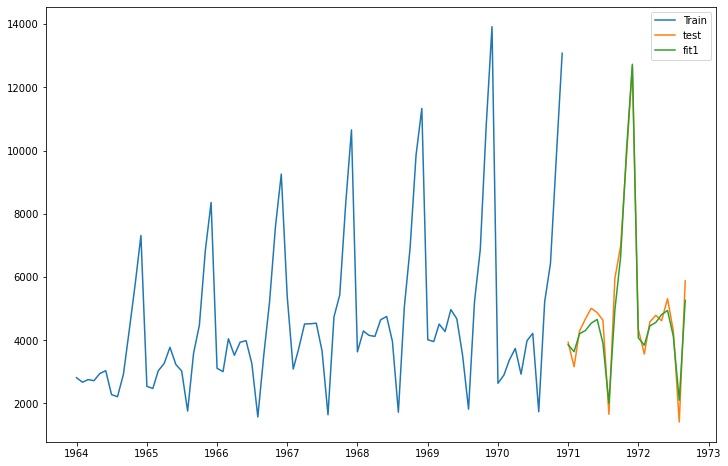

In [29]:
model_hw = ExponentialSmoothing(X_train, trend='add', seasonal='add', seasonal_periods=12).fit(use_boxcox=True)
temp_test['hw_fit1'] = model_hw.forecast(X_test.shape[0])
fit1_rmse, fit1_mape = calc_residual(temp_test, 'Sales', 'hw_fit1')
print("fit1: rmse {} and mape {}".format(fit1_rmse, fit1_mape))
plot_graph(X_train,temp_test, 'Sales', 'hw_fit1', 'fit1')

K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning


fit1: rmse 694.2652151998501 and mape 0.132


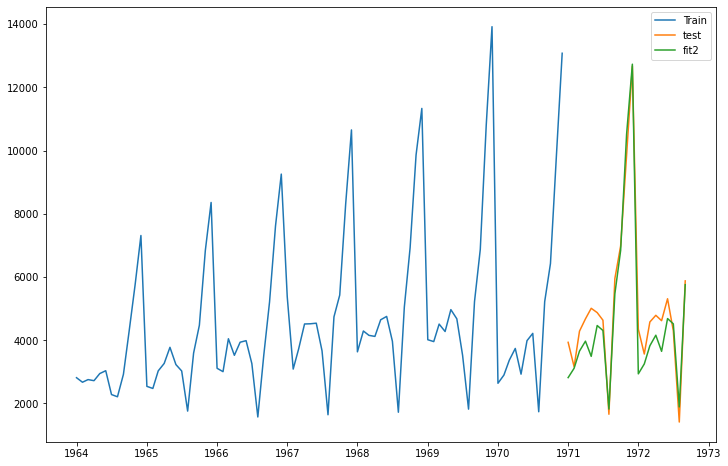

In [30]:
model_hw_fit2 = ExponentialSmoothing(X_train, trend='add', seasonal='mul', seasonal_periods=12).fit(use_boxcox=True)
temp_test['hw_fit2'] = model_hw_fit2.forecast(X_test.shape[0])
fit2_rmse, fit2_mape = calc_residual(temp_test, 'Sales', 'hw_fit2')
print("fit1: rmse {} and mape {}".format(fit2_rmse, fit2_mape))
plot_graph(X_train,temp_test, 'Sales', 'hw_fit2', 'fit2')

K:\MachineLearning\logistic_regression\venv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  """Entry point for launching an IPython kernel.
K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning


fit3: rmse 564.4320395230371 and mape 0.111


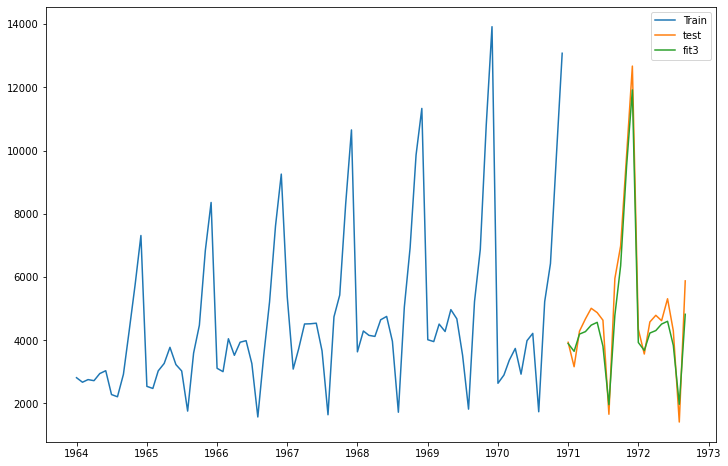

In [31]:
model_hw_fit3 = ExponentialSmoothing(X_train, trend='add', seasonal='add', seasonal_periods=12, damped=True).fit(use_boxcox=True)
temp_test['hw_fit3'] = model_hw_fit3.forecast(X_test.shape[0])
fit3_rmse, fit3_mape = calc_residual(temp_test, 'Sales', 'hw_fit3')
print("fit3: rmse {} and mape {}".format(fit3_rmse, fit3_mape))
plot_graph(X_train, temp_test, 'Sales', 'hw_fit3', 'fit3')

K:\MachineLearning\logistic_regression\venv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  """Entry point for launching an IPython kernel.
K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
K:\MachineLearning\logistic_regression\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning


fit1: rmse 559.1343626597195 and mape 0.11


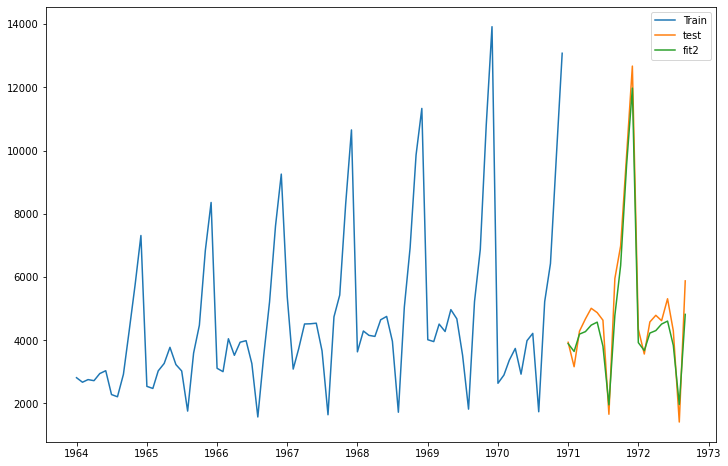

In [32]:
model_hw_fit4 = ExponentialSmoothing(X_train, trend='add', seasonal='mul', seasonal_periods=12, damped=True).fit(use_boxcox=True)
temp_test['hw_fit4'] = model_hw_fit4.forecast(X_test.shape[0])
fit4_rmse, fit4_mape = calc_residual(temp_test, 'Sales', 'hw_fit4')
print("fit1: rmse {} and mape {}".format(fit4_rmse, fit4_mape))
plot_graph(X_train,temp_test, 'Sales', 'hw_fit4', 'fit2')

Out of the 4 fits, I can see the fit1 is having less residuals.


In [33]:
X_test['hw'] = temp_test['hw_fit1']
comparing_list.append(['Holt-Winter', fit1_rmse, fit1_mape])

K:\MachineLearning\logistic_regression\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
df=pd.DataFrame(comparing_list,columns=['Method','RMSE', 'MAPE'])
df

,Method,RMSE,MAPE
0,Simple Average,2427.539522,0.361
1,moving average,1658.371767,0.282
2,SimpleExpSm0othing,3170.844080,0.833
3,Holt linear Trend Method,24573.341095,6.036
4,Exponential Trend Method,835441.052274,148.555
5,Additive damped Method,835441.052274,148.555
6,Holt-Winter,421.403875,0.094
